O dataset contém os microdados do ENEM 2021, que incluem informações sobre notas, renda familiar, tipo de escola, estado, idade e gênero.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Lendo a tabela que será utilizada
enem2021 = pd.read_csv(r"C:\Users\kevel\OneDrive\Área de Trabalho\Data Scyentist\PROJETO DE DS\ENEM 2021\DADOS\MICRODADOS_ENEM_2021.csv", sep=";", encoding='latin1')


Renomeando colunas para facilitar a leitura
Algumas colunas têm nomes pouco intuitivos, então renomeamos para facilitar a análise.


In [ ]:

df = enem2021.rename(columns={
    'NU_NOTA_CN': 'Ciências da Natureza',
    'NU_NOTA_CH': 'Ciências Humanas',
    'NU_NOTA_LC': 'Linguagens',
    'NU_NOTA_MT': 'Matemática',
    'Q006': 'Renda Familiar',
    'TP_ESCOLA': 'Tipo de Escola',
    'SG_UF_PROVA': 'UF',
    'TP_SEXO': 'Gênero',
    'TP_FAIXA_ETARIA': 'Idade'
})


Mapeamento da Renda Familiar para valores numéricos
Como os dados de renda são categóricos (letras de A a Q), foi criada uma conversão para valores numéricos.


In [4]:
# Verifica os valores únicos na coluna 'Renda Familiar'
print(df['Renda Familiar'].unique())

# Mapeamento da Renda Familiar para valores numéricos
renda_map = {
    'A': 0, 'B': 606, 'C': 1515, 'D': 2121, 'E': 2727, 'F': 3333, 'G': 4242, 'H': 5454, 'I': 6666, 
    'J': 7878, 'K': 9090, 'L': 10302, 'M': 11514, 'N': 13332, 'O': 16362, 'P': 21210, 'Q': 24240
}
df['Renda Numérica'] = df['Renda Familiar'].map(renda_map)

# Aplica o mapeamento e substitui valores não encontrados por NaN
df['Renda Numérica'] = df['Renda Familiar'].map(renda_map)

# Converte para numérico, garantindo que os valores ausentes sejam tratados
df['Renda Numérica'] = pd.to_numeric(df['Renda Numérica'], errors='coerce')

# Remove linhas com valores NaN em 'Renda Numérica'
df = df.dropna(subset=['Renda Numérica'])



['D' 'B' 'C' 'G' 'H' 'F' 'E' 'A' 'I' 'L' 'J' 'N' 'O' 'K' 'M' 'Q' 'P' nan]


Este bloco gera histogramas das notas de cada área do ENEM. Os histogramas ajudam a visualizar como as notas estão distribuídas.

São apresentados os histogramas das notas de Ciências da Natureza, Ciências Humanas, Linguagens e Matemática.

Observa-se que as distribuições seguem um padrão assimétrico, com maior concentração de notas médias e poucas notas muito baixas ou muito altas.

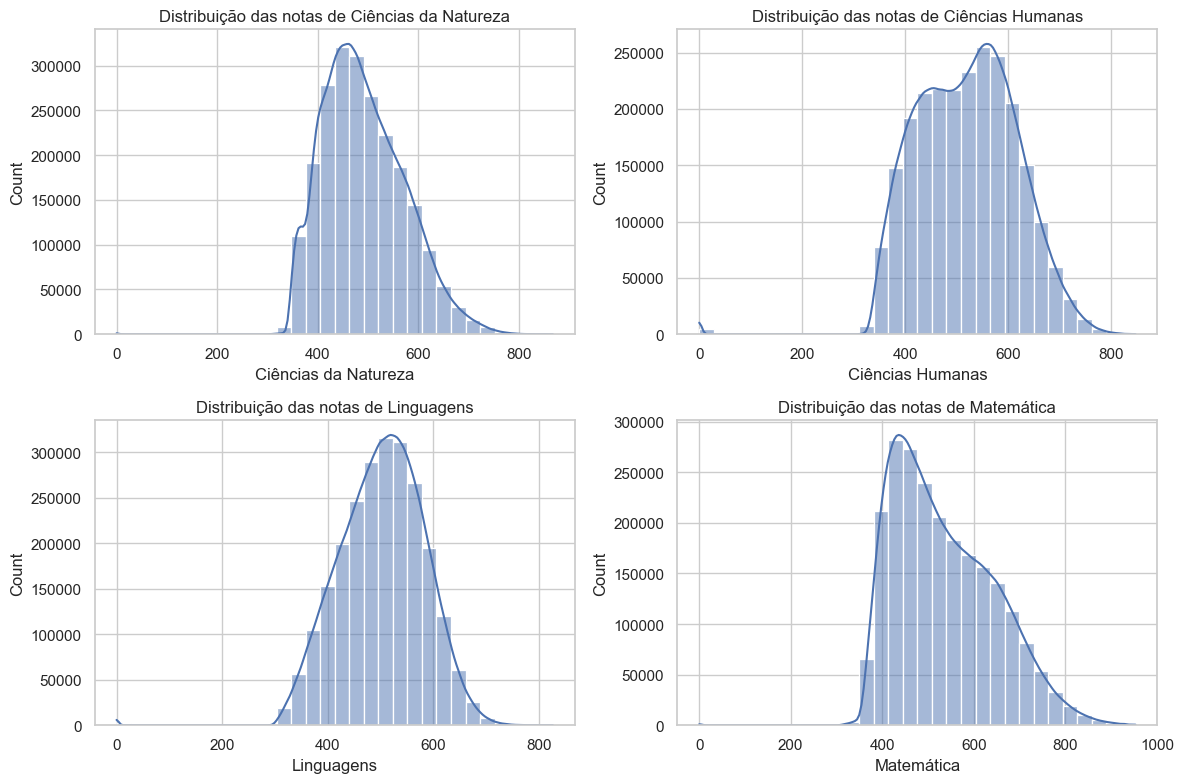

In [ ]:
# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

# Distribuição das notas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
notas = ['Ciências da Natureza', 'Ciências Humanas', 'Linguagens', 'Matemática']
for i, ax in enumerate(axes.flatten()):
    sns.histplot(df[notas[i]].dropna(), bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribuição das notas de {notas[i]}')
plt.tight_layout()
plt.show()

A maior parte dos participantes pertence às faixas de renda mais baixas.

Há um grande desbalanceamento entre as categorias, com poucas pessoas em faixas de renda mais altas.

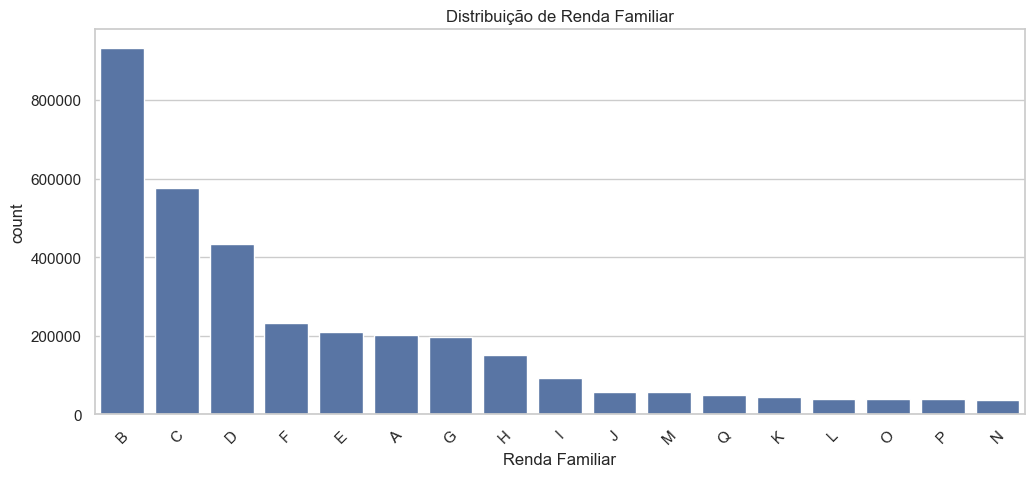

In [6]:
# Análise detalhada das variáveis socioeconômicas
plt.figure(figsize=(12, 5))
sns.countplot(x='Renda Familiar', data=df, order=df['Renda Familiar'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribuição de Renda Familiar')
plt.show()

A maioria dos candidatos estudou em escolas públicas, indicando uma representatividade maior desse grupo no exame.

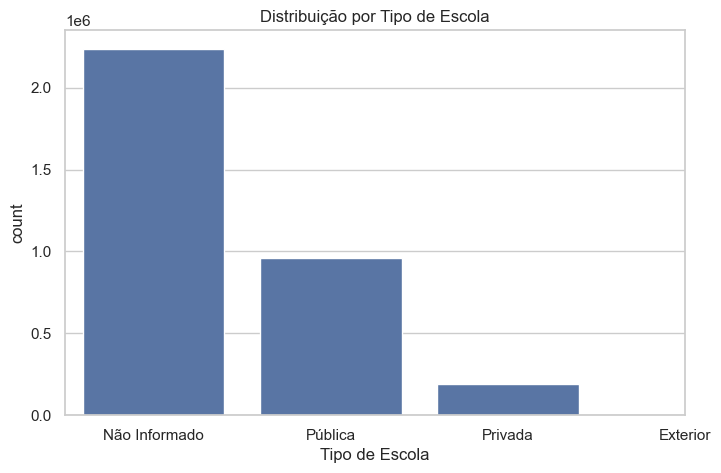

In [7]:


plt.figure(figsize=(8, 5))
sns.countplot(x='Tipo de Escola', data=df)
plt.title('Distribuição por Tipo de Escola')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Não Informado', 'Pública', 'Privada', 'Exterior'])
plt.show()

Os estados mais populosos, como São Paulo, Minas Gerais e Bahia, têm um maior número de candidatos inscritos.

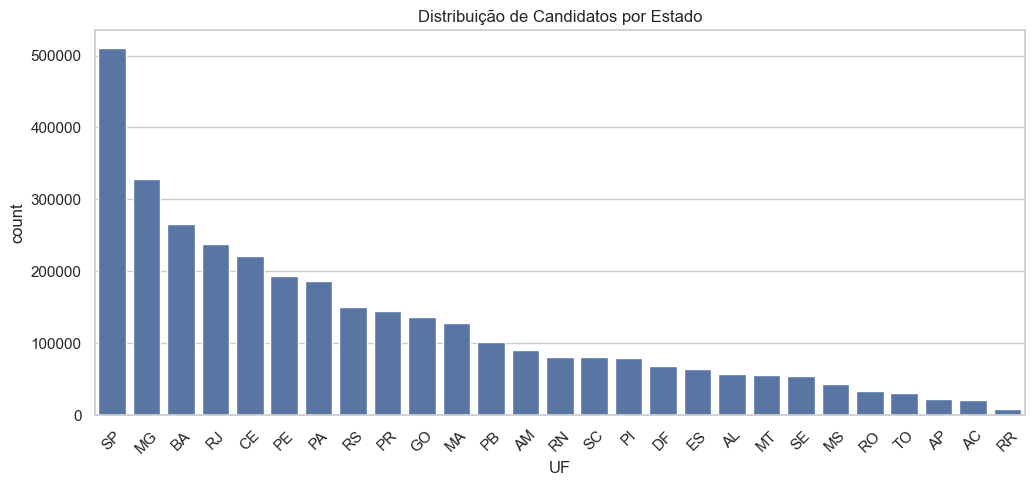

In [8]:
plt.figure(figsize=(12, 5))
sns.countplot(x='UF', data=df, order=df['UF'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribuição de Candidatos por Estado')
plt.show()

Nota-se um número ligeiramente maior de candidatas do gênero feminino em comparação aos candidatos do gênero masculino.

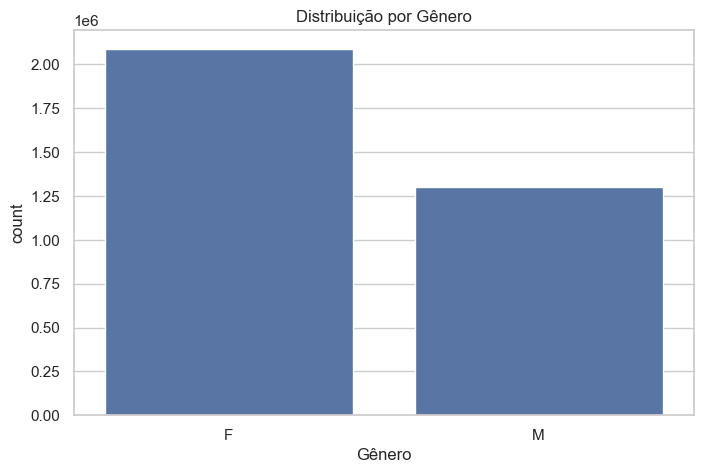

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Gênero', data=df)
plt.title('Distribuição por Gênero')
plt.show()

Foram gerados gráficos de dispersão para visualizar a relação entre renda e notas.

In [11]:
# Verificando se a coluna foi criada corretamente
print(df[['Renda Familiar', 'Renda Numérica']].head())

# Removendo linhas onde 'Renda Numérica' está faltando
df = df.dropna(subset=['Renda Numérica'])

# Convertendo para numérico para evitar erros
df['Renda Numérica'] = pd.to_numeric(df['Renda Numérica'])


  Renda Familiar  Renda Numérica
0              D          2121.0
1              B           606.0
2              C          1515.0
3              B           606.0
4              C          1515.0


A tendência indica uma leve correlação positiva entre renda e desempenho, ou seja, alunos com maior renda tendem a ter notas um pouco mais altas.

No entanto, a dispersão dos pontos sugere que há muitos outros fatores influenciando o desempenho além da renda.

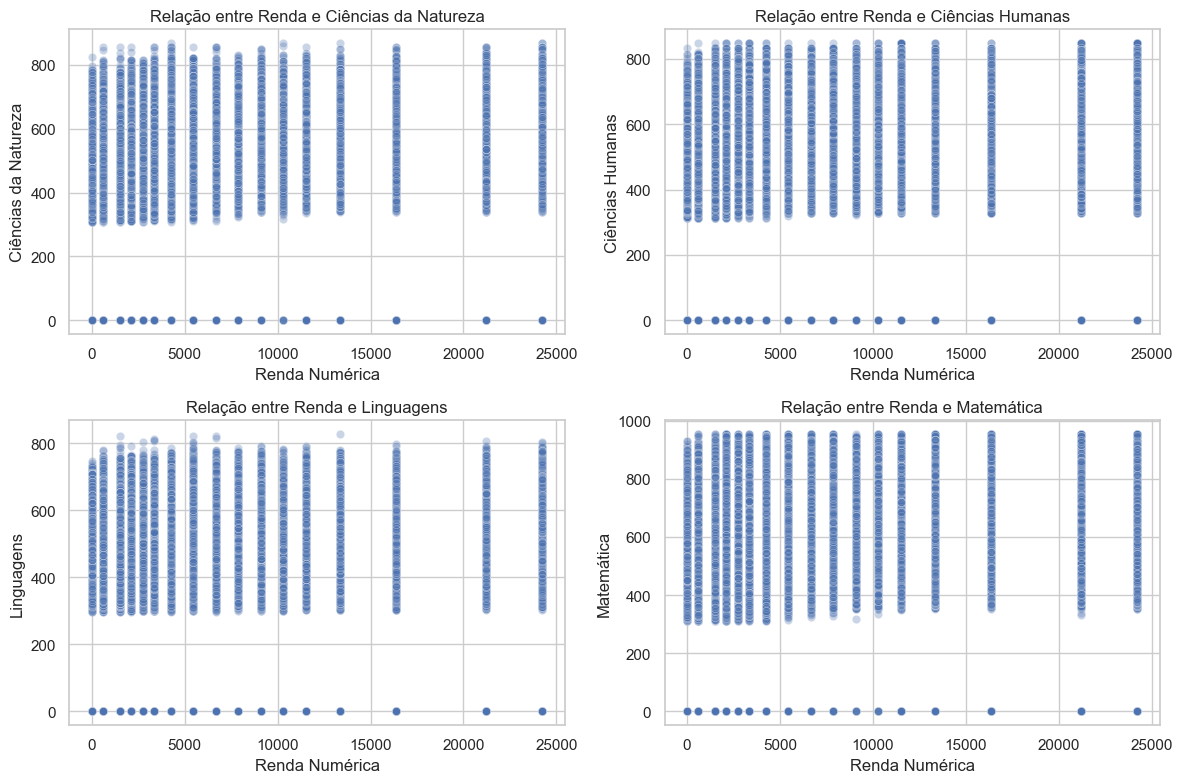

In [12]:
# Correlação entre notas e renda
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(x=df['Renda Numérica'], y=df[notas[i]], alpha=0.3, ax=ax)
    ax.set_title(f'Relação entre Renda e {notas[i]}')
plt.tight_layout()
plt.show()

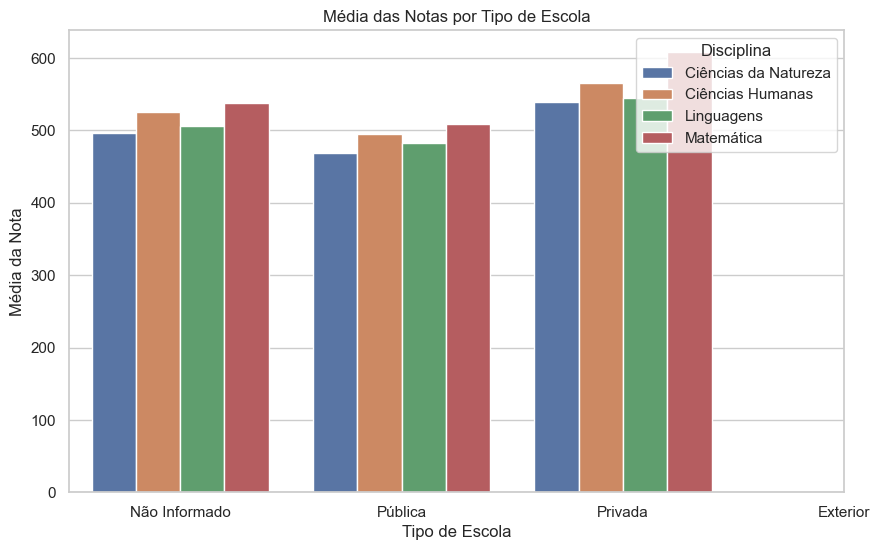

In [13]:
# Comparação das médias das notas por tipo de escola e região
plt.figure(figsize=(10, 6))
df_grouped = df.groupby('Tipo de Escola')[notas].mean().reset_index()
df_melted = df_grouped.melt(id_vars=['Tipo de Escola'], var_name='Disciplina', value_name='Média da Nota')
sns.barplot(x='Tipo de Escola', y='Média da Nota', hue='Disciplina', data=df_melted)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Não Informado', 'Pública', 'Privada', 'Exterior'])
plt.title('Média das Notas por Tipo de Escola')
plt.show()

Foi treinado um modelo de Random Forest para prever a nota de Matemática com base na renda, tipo de escola e idade.

A validação cruzada resultou em um R² médio baixo, indicando que essas variáveis isoladamente não explicam bem a nota de Matemática.

In [14]:
# Validação cruzada com Random Forest
X = df[['Renda Numérica', 'Tipo de Escola', 'Idade']]
X = pd.get_dummies(X, columns=['Tipo de Escola'], drop_first=True)
y = df['Matemática'].dropna()
X = X.loc[y.index]

rf = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f'R² médio da validação cruzada: {scores.mean():.4f}')

R² médio da validação cruzada: 0.2271


O PCA foi utilizado para reduzir a dimensionalidade dos dados de notas.

O primeiro componente principal (PC1) explica a maior parte da variância, sugerindo que as notas das diferentes disciplinas têm padrões semelhantes.

A visualização do PCA mostra que os alunos de escolas públicas e privadas tendem a se distribuir de maneira diferente no espaço de componentes principais.

In [15]:
# PCA
scaler = StandardScaler()
df_notas_scaled = scaler.fit_transform(df[notas].dropna())
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_notas_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

explained_variance = pca.explained_variance_ratio_
print(f'Variância explicada pelo PC1: {explained_variance[0]:.2f}')
print(f'Variância explicada pelo PC2: {explained_variance[1]:.2f}')

Variância explicada pelo PC1: 0.75
Variância explicada pelo PC2: 0.11


In [17]:
# Remover linhas com NaN apenas das colunas de notas
df_notas = df[notas].dropna()

# Normalizar e aplicar PCA apenas nas linhas existentes
scaler = StandardScaler()
df_notas_scaled = scaler.fit_transform(df_notas)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_notas_scaled)

# Criar o DataFrame PCA garantindo os índices corretos
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=df_notas.index)


In [18]:
missing_indexes = df_pca.index.difference(df.index)
if not missing_indexes.empty:
    print("Índices ausentes no df:", missing_indexes)


<Axes: xlabel='PC1', ylabel='PC2'>

C:\Users\kevel\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\kevel\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


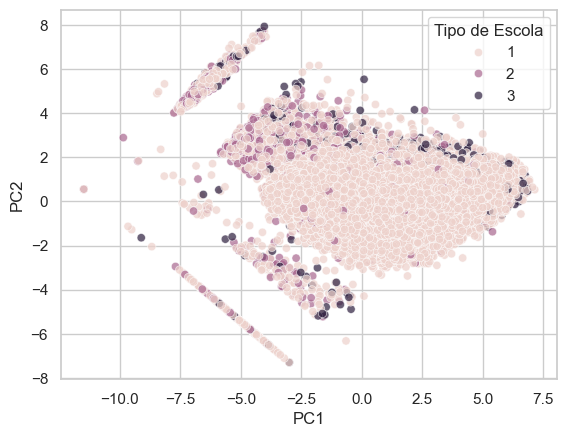

In [19]:
common_index = df_pca.index.intersection(df.index)
sns.scatterplot(x=df_pca.loc[common_index, 'PC1'], 
                y=df_pca.loc[common_index, 'PC2'], 
                hue=df.loc[common_index, 'Tipo de Escola'], 
                alpha=0.7)


Conclusões e Melhorias

Exploração de Novas Variáveis: A baixa correlação entre renda e notas sugere que outras variáveis, como escolaridade dos pais e acesso a recursos educacionais, poderiam melhorar as análises.

Modelos de Machine Learning: O modelo de Random Forest apresentou desempenho baixo. Testar regressões lineares, modelos de deep learning ou adicionar mais features pode melhorar as previsões.

Análise Temporal: Comparar os dados com edições anteriores do ENEM pode revelar tendências e mudanças no perfil dos candidatos ao longo dos anos.

Normalização de Dados: Algumas variáveis poderiam ser melhor normalizadas para melhorar a análise estatística e o desempenho dos modelos.

Este notebook fornece uma visão inicial sobre os padrões do ENEM 2021, mas há espaço para aprofundar as investigações e aprimorar os modelos de análise.